In [162]:
import pandas as pd
import numpy as np
import torchaudio
from pathlib import Path
from fastai.vision.all import *
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from sklearn.model_selection import StratifiedKFold, GroupKFold
import librosa
import soundfile as sf

In [163]:
SEED = 42
DATA_PATH = Path("./birdclef-2022/")
AUDIO_PATH = Path("./birdclef-2022/train_audio")

NUM_WORKERS = 4
CLASSES = sorted(os.listdir(AUDIO_PATH))
NUM_CLASSES = len(CLASSES)
class AudioParams:
    # audio data
    sr = 32000
    duration = 5

    # Melspectrogram
    n_mels = 224
    fmin = 20
    fmax = 16000

In [164]:
train = pd.read_csv(DATA_PATH / 'train_metadata.csv')
train["file_path"] = AUDIO_PATH / train['filename']
paths = train["file_path"].values

train_spectrograms = pd.DataFrame(columns=train.columns)

In [165]:
def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(
        y=y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax,
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec

In [166]:
def pad(audio, length):
    padding_length = length - (len(audio) % length)
    padding = np.zeros(padding_length)
    audio = np.concatenate([audio, padding])
    return audio.astype(np.float32)

a = np.arange(10)
b = pad(a, 20)
print(b)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [167]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    # X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [168]:
def chunk(array, chunk_size):
    indices = np.arange(chunk_size, len(array), chunk_size)
    return np.split(array, indices)

arr = np.arange(20)
chunk(arr, 7)


[array([0, 1, 2, 3, 4, 5, 6]),
 array([ 7,  8,  9, 10, 11, 12, 13]),
 array([14, 15, 16, 17, 18, 19])]

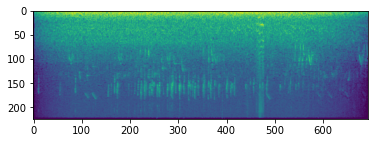

In [169]:
# original

path = train['file_path'][0]
y, sr = sf.read(path, always_2d=True)
y = np.mean(y, 1)

X = compute_melspec(y, AudioParams)
X = mono_to_color(X)
X = X.astype(np.uint8)

plt.imshow(X)

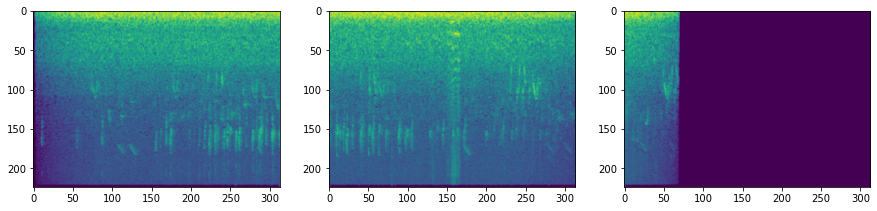

In [170]:
# 5 sec cropped

path = train['file_path'][0]
audio, sample_rate = sf.read(path, always_2d=True)
chunk_size = AudioParams.duration * sample_rate
audio = np.mean(audio, 1)
audio = pad(audio, chunk_size)
chunks = chunk(audio, chunk_size) 

num_chunks = len(chunks)
plt.subplots(figsize=(num_chunks*5, 5))

for i, audio_chunk in enumerate(chunks):
    X = compute_melspec(audio_chunk, AudioParams)
    X = mono_to_color(X)
    X = X.astype(np.uint8)

    plt.subplot(1, num_chunks, i+1)
    plt.imshow(X)

plt.show()

In [171]:
def Audio_to_Images(path, params):

    # Read in the audio file
    audio, sample_rate = sf.read(path, always_2d=True)

    # Chunk and pad the audio
    chunk_size = params.duration * sample_rate
    audio = np.mean(audio, 1)
    audio = pad(audio, chunk_size)
    chunks = chunk(audio, chunk_size) 

    # Chunk -> MEL spectrogram
    spectrograms = []
    for audio_chunk in chunks:
        spectrogram = compute_melspec(audio_chunk, params)
        spectrogram = mono_to_color(spectrogram)
        spectrogram = spectrogram.astype(np.uint8)
        spectrograms.append(spectrogram)
    
    return spectrograms

In [173]:
def save_(path, train_spectrograms):

    spectrograms = Audio_to_Images(path, AudioParams)

    for i, spectrogram in enumerate(spectrograms):

        filename = path.stem + "_" + str((i+1) * 5)
        save_path = DATA_PATH / "spectograms_full" / path.parts[2] / filename
        np.save(save_path, spectrogram)

        metadata = train.loc[train["file_path"] == path].copy()
        metadata.filename = filename
        metadata.file_path = save_path

        train_spectrograms = pd.concat([train_spectrograms, metadata])

    return train_spectrograms

# from os.path import exists

# if exists("tmp"):
#     if exists("tmp/test.npy"):
#         os.remove("tmp/test.npy")
# else:
#     os.makedirs("tmp", exist_ok=False)
# path = train['file_path'][0]
# print(path)
# train_spectrograms = save_(path, train_spectrograms)

In [174]:
train = pd.read_csv(DATA_PATH / 'train_metadata.csv')
train["file_path"] = AUDIO_PATH / train['filename']
paths = train["file_path"].values

train_spectrograms = pd.DataFrame(columns=train.columns)

# Create the folder structure for the images
for dir_ in CLASSES:
    dir_path = DATA_PATH / "spectograms_full" / dir_
    _ = os.makedirs(dir_path, exist_ok=True)

# Convert audio files and save images
for audio_path in tqdm(paths):
    train_spectrograms = save_(audio_path, train_spectrograms)

# Save new metadata
train_spectrograms.to_csv("train_spectrograms.csv", index = False)

  0%|          | 0/14852 [00:00<?, ?it/s]